<a href="https://colab.research.google.com/github/OlgaSeleznova/ML_toolbox/blob/main/LSTM_Text_Classification_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# load data
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Libraries

In [30]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

# Preliminaries
from torchtext.legacy import data

# Models
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training
import torch.optim as optim
import torch.nn.functional as F

# Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Preliminaries

In [31]:
# create cuda device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Fields
def tokenize(s): return s.split(' ')
LABEL = data.LabelField(use_vocab=False, batch_first=True, dtype=torch.int)
TEXT = data.Field(tokenize=tokenize, lower=True, include_lengths=True, batch_first=True)
fields = [('text', TEXT),('label', LABEL)]

# TabularDataset
source_folder = '/content/drive/My Drive/ML_toolbox/data/eng_lyrics'

train, valid, test = data.TabularDataset.splits(path=source_folder, train = 'train.csv', validation = 'valid.csv', test = 'test.csv',
                                          format='CSV', fields=fields, skip_header=True)
# Iterators
def create_iterator(dataset):
    return data.BucketIterator(dataset, batch_size=32, sort_key=lambda x: len(x.text), device=device, sort=False, sort_within_batch=True, shuffle=True)
    
train_iter = create_iterator(train)
valid_iter = create_iterator(valid)
test_iter = create_iterator(test)

# Create vocabulary from train set
TEXT.build_vocab(train, min_freq=3)

cuda:0


# Model

In [32]:
class LSTM(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

# Training

In [33]:
def train_model(model, train_iter, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    labels_true = []
    labels_pred = []
    validation_acc = []
    delta = 0.001
    i=0
    while i < epochs:
        i+=1
        model.train()
        sum_loss = 0.0
        total = 0
        for (text,text_len), labels in train_iter:
            #send variables to cuda
            labels = labels.to(device)
            text_len = text_len.cpu().to(device)
            text = text.to(device)
            #forward pass
            output = model(text, text_len)
            optimizer.zero_grad()
            loss = F.cross_entropy(output, labels.long()).to(device)
            #backward pass
            loss.backward()
            optimizer.step()
            # validate model
            sum_loss += loss.item()*labels.shape[0]
            total += labels.shape[0]
        val_loss, val_acc, val_rmse, label_pred, label_true = validation_metrics(model, valid_iter)
        #convert tensor to float 
        val_acc = val_acc.item()
        #save stats
        labels_pred.append(label_pred.detach().cpu().numpy())
        labels_true.append(label_true.detach().cpu().numpy())
        validation_acc.append(val_acc)
        print("epoch %.0f, train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (i, sum_loss/total, val_loss, val_acc, val_rmse))
        #create a stopping criteria
        if i > 5:
            if (val_acc-validation_acc[-3] < delta) and (val_acc-validation_acc[-2] < delta):
                break
        else:
            continue
    return labels_pred, labels_true

def validation_metrics (model, valid_iter):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for (text, text_len), labels in valid_iter:
        labels = labels.to(device)
        text_len = text_len.cpu().to(device)
        text = text.to(device)
        #forward pass
        output = model(text,text_len)
        #calculate loss and labels prediction 
        loss = F.cross_entropy(output, labels.long()).to(device)
        pred = torch.max(output, 1)[1]
        # save statistics
        correct += (pred == labels).float().sum()
        total += labels.shape[0]
        sum_loss += loss.item()*labels.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred.cpu(), labels.cpu().unsqueeze(-1)))*labels.cpu().shape[0]
    return sum_loss/total, correct/total, sum_rmse/total, pred, labels

In [34]:
model =  LSTM (len(TEXT.vocab), 300, 128).to(device)
genre_pred, genre_true = train_model(model, train_iter, epochs=30, lr=0.001)

epoch 1, train loss 1.304, val loss 1.203, val accuracy 0.502, and val rmse 1.640
epoch 2, train loss 1.073, val loss 1.086, val accuracy 0.565, and val rmse 1.708
epoch 3, train loss 0.958, val loss 1.049, val accuracy 0.587, and val rmse 1.547
epoch 4, train loss 0.878, val loss 1.040, val accuracy 0.603, and val rmse 1.532
epoch 5, train loss 0.784, val loss 1.127, val accuracy 0.570, and val rmse 1.633
epoch 6, train loss 0.722, val loss 1.063, val accuracy 0.613, and val rmse 1.541
epoch 7, train loss 0.642, val loss 1.089, val accuracy 0.613, and val rmse 1.535
epoch 8, train loss 0.586, val loss 1.154, val accuracy 0.614, and val rmse 1.527
epoch 9, train loss 0.524, val loss 1.195, val accuracy 0.614, and val rmse 1.504
epoch 10, train loss 0.480, val loss 1.267, val accuracy 0.611, and val rmse 1.534


# Evaluation

              precision    recall  f1-score   support

        Rock       0.49      0.37      0.42        78
         Pop       0.49      0.50      0.49        68
     Hip-Hop       0.45      0.74      0.56        39
       Metal       0.71      0.72      0.72        75
     Country       0.69      0.58      0.63        60

    accuracy                           0.57       320
   macro avg       0.57      0.58      0.57       320
weighted avg       0.57      0.57      0.56       320

Confusion matrix:
 [[29 16 12 12  9]
 [13 34  9  6  6]
 [ 3  4 29  2  1]
 [ 9  4  8 54  0]
 [ 5 12  6  2 35]] 



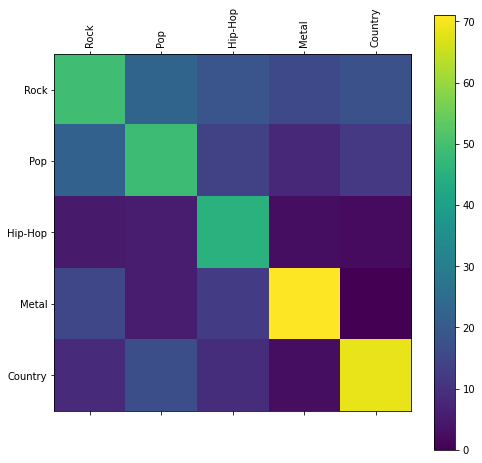

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


def plot_cm(y, pred, target_names=''):
    conf_m = confusion_matrix(y, pred)
    print('Confusion matrix:\n', conf_m, '\n')

    fractions = (conf_m / conf_m.sum(axis=0) * 100.0).round(2)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(fractions)
    fig.colorbar(cax)

    # set up axes
    labels = [''] + list(target_names)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)
    
    # force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

#encoded genre names
genre_srt_to_int = {'Rock':0, 'Pop':1, 'Hip-Hop':2, 'Metal':3, 'Country':4}
#stack labels
genre_pred_,genre_true_ = np.concatenate(genre_pred),np.concatenate(genre_true)
#print classification report and visualize confusion matrix
print(classification_report(genre_true_, genre_pred_, target_names=list(genre_srt_to_int.keys())))
plot_cm(genre_true_, genre_pred_, target_names=list(genre_srt_to_int.keys()))